```Give a brief description of your idea```(6500)

```
1)Price Optimization – With the increase in 
competition, dynamic pricing is very important to 
compete on pricing with other sites. To achieve this, 
companies collect data from multiple sources, such 
as sales information, competitor pricing and customer 
actions, to determine the right price for the sale of 
products.companies do try different models and techniques to determine best price for the product and also differnt machine learning techniques to get best out of it!

Changing in Prices of doesn’t directly impact the product, but is rather effact through many individual consumer decisions to buy or not buy and also make a bad impression on the brand

To tackle this issue we can try to causal inference (randomized) experimentation: But We have to try differenct prices in different seasons it actually cost a lot to the retailer!

To know the best price is to simply analyze retailer’s history of prices and units sold over time. But estimating causal effects from observational data is difficult because of confounding. To see what this means, consider (1)Brand (2)Seasons and (3)Product Quality are important examples of many potential confounders
```

 Problem Statement 
```
Please use this space to describe the problem you wish to solve. A good problem statement addresses the following (but not limited to): What is the problem and who has it? Where and when does the problem occur?```

```
Price optimization is at the root of the force needed for profit generation in retail. The backbone of retail pricing analytics is science, which is used to price items correctly without the need to discount them.
As in the game of chess, the retailer needs to set optimal prices to neutralize the competitors or to milk their weaknesses. This task becomes complicated, given the proliferation of categories and the high dynamics of prices.
Promotion pressure or volume per deal has significantly increased in recent years. Vendors (brands) and retailers often start promo wars which usually lead to the loss in sales or the market share. It is impossible to determine the strategy to use at the beginning: whether to activate or deactivate deep discounts, or offer low prices every day.
Dynamic Pricing is a non-linear relationship between the sales volume and price: the more elastic the prices, the more they influence the sales. It is difficult to calculate the right price that would maximize revenue (will maximize the price per product and the number of products sold)```

Briefly describe how your idea solves this problem 
```Use this space to elaborate on your solution and tell us about the tech stack you're using```

```our idea solves two issues: First, regularization picks appropriate controls out of a large number of potential confounders. Second, since I’m using a flexible machine learning algorithm
My solution implements Double Machine Learning (DML). 
To do this, I train two separate, “auxiliary” models to predict the treatment (price, P) and the outcome (quantity demanded, Q), respectively. The models are both trained independently with a set X of potential confounding variables (product quality and season), so that their predictions approximate expected values, E[P|X] and E[Q|X].
Using these predictions, I then residualize out the parts of treatment and effect that are predictable through the set of control variables
In my implementation below, I choose XGBoost to estimate the conditional expectations, chosen for their robust performance. You can think of these two auxiliary models as “control models”: If X contains enough information about the relevant confounders, and if at least one of the models fits well, by construction P̃ and Q̃ are now unconfounded and only the true causal relationship remains 
My Approach:-
I’ll take logs of p and q.
I’ll construct a set of potential confounders, X.
I’ll train an auxiliary XGBoost model to predict log(p) from X.
I’ll train a separate auxiliary RandomForest model to predict log(q) from X.
Split the dataset into two halves, and take logs of p and q.
Construct a set of potential confounders X (same variables in both halves).
Use the first half to train an auxiliary XGBoost model to predict log(p) from X.
Use the first half to train a separate auxiliary RandomForest model to predict log(q) from X.
Use the two auxiliary models to predict log(p) and log(q) from X in the second half of the data, to obtain after residualizing
Infer elasticity as the coefficient of a linear regression,
Repeat steps 3–6 with the two halves swapped out. Use the mean of both θ-estimates as final result.
 ```

Please provide a 2-minute video of a working demo of your solution
*
```Paste the YouTube link to your demo video in this section. If you want your video to be private, ensure you change the settings such that we can view it.```

In [1]:
import pandas as pd, numpy as np
from datetime import datetime, date
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_parquet('df_pre_processed.parquet')

In [3]:
df.set_index(['Date', 'StockCode', 'Country']).sample(10)

,,,Description,Quantity,revenue,UnitPrice
Date,StockCode,Country,,,,
2011-11-20,23341,United Kingdom,PINK DINER WALL CLOCK,3,25.50,8.500000
2011-08-01,20726,United Kingdom,LUNCH BAG WOODLAND,20,33.00,1.650000
2011-07-21,23239,European Community,SET OF 4 KNICK KNACK TINS POPPIES,6,24.90,4.150000
2011-09-21,22107,United Kingdom,PIZZA PLATE IN BOX,15,49.35,3.290000
2011-09-22,82552,United Kingdom,WASHROOM METAL SIGN,12,17.40,1.450000
2011-09-26,22737,United Kingdom,RIBBON REEL CHRISTMAS PRESENT,1,3.29,3.290000
2011-07-07,22249,United Kingdom,DECORATION WHITE CHICK MAGIC GARDEN,2,1.66,0.830000
2011-10-07,21823,United Kingdom,PAINTED METAL HEART WITH HOLLY BELL,8,6.64,0.830000
2011-11-18,84580,United Kingdom,MOUSE TOY WITH PINK T-SHIRT,1,4.13,4.130000


In [4]:
df=df.iloc[10000:20000]

In [5]:
df.shape

(10000, 7)

<AxesSubplot:title={'center':'number of items sold and revenue over time'}, xlabel='Date'>

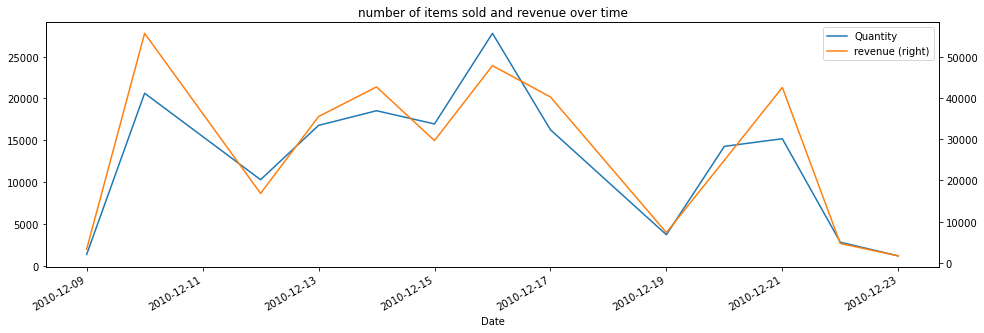

In [6]:
df.groupby('Date').agg(
    {'Quantity': 'sum', 'revenue': 'sum'}
).plot(
    title='number of items sold and revenue over time', 
    secondary_y='revenue',
    figsize=(16, 5)
)

```For identification of elasticity, we need variation in prices within products - otherwise we can never disambiguate price-responses from product preferences.```

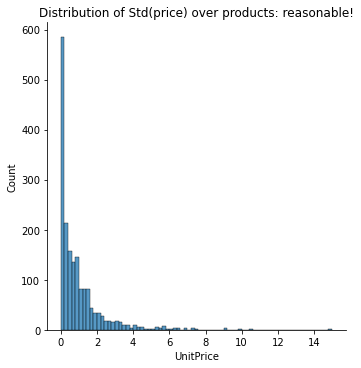

In [7]:
sns.displot(df.groupby('StockCode').UnitPrice.std().dropna().clip(0, 15), kde=False)
plt.title('Distribution of Std(price) over products: reasonable!');

In [8]:
len(df)

10000

In [9]:
df_mdl = df[
    (df.groupby('StockCode').UnitPrice.transform('std') > 0)
]
del df

In [10]:
len(df_mdl)

8309

```
Background: price elasticity of demand
"It is a known fact" of economics that price elasticities exist ("analyst inductive bias/prior"). Elasticity is basically a fancy way to say "derivative of demanded quantity with respect to price". But there's a twist: elasticity is relative derivatives:

 
This is not just economists being fancy. Empirically, it is often a decent heuristic that  is constant in  - which the derivates itself are not. In other words, demand can be (locally) approximated to be an exponential function in p:

Knowing this functional form makes our lives much easier later. Note that we can take

 
In other words, in log-log-space elasticity is just the coefficient of linear regression.

Since we can only learn from within-product price variation, we can discard all observations that do not contain information, i.e. where we do not see purchases at multiple different prices
```

In [11]:
df_mdl = df_mdl.assign(
    LnP = np.log(df_mdl['UnitPrice']),
    LnQ = np.log(df_mdl['Quantity']),
)

```
Do the naive analysis first
Let's confuse correlation & causation! In this example, price seems weakly negatively correlated with demand (the next chapter explains the purpose of -ing variables).

Since the regression coefficient is , this naive calculation would yield elasticity of around 
 
.

The following real analysis will show that this significantly underestimates the causal effect (i.e. we will under-estimate the demand drop that is expected when raising prices).
```

In [12]:
df_mdl[['LnP', 'LnQ']].cov()

,LnP,LnQ
LnP,0.829295,-0.454842
LnQ,-0.454842,1.901231


Now for the real analysis: price elasticity of demand

In [13]:
import statsmodels.api as sm # get full stats on regressions

def binned_ols(df, x, y, n_bins, plot=True, plot_title='', plot_ax=None, **plt_kwargs):
    # A visual form of de-noising: bin explanatory variable first, 
    # then take means-per-bin of variable to be explaioned, then
    # regress/plot 
    x_bin = x + '_bin'
    df[x_bin] = pd.qcut(df[x], n_bins)

    tmp = df.groupby(x_bin).agg({
        x: 'mean',
        y: 'mean'
    })

    if plot:
        tmp.plot(
            x=x, 
            y=y,
            figsize=(18, 6),
            title=plot_title,
            ax=plot_ax,
            **plt_kwargs
        )
    
    del df[x_bin]
    mdl = sm.OLS(tmp[y], sm.add_constant(tmp[x]))
    res = mdl.fit()
    return res

"Naive" elasticity estimated to be -0.5603305074105336


C:\ancon\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    LnQ   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     58.97
Date:                Sat, 20 Aug 2022   Prob (F-statistic):           3.49e-06
Time:                        15:27:31   Log-Likelihood:                0.51653
No. Observations:                  15   AIC:                             2.967
Df Residuals:                      13   BIC:                             4.383
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2870      0.093     24.488      0.000       2.085       2.489
LnP           -0.5603      0.073     -7.679      0.000      -0.718      -0.403
==============================================================================
Omnibus:                        5.011   Durbin-Watson:                   2.821
Prob(Omnibus):                  0.082   Jarque-Bera (JB):                3.097
Skew:                          -1.112   Prob(JB):                        0.213
Kurtosis:                       3.104   Cond. No.                         2.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

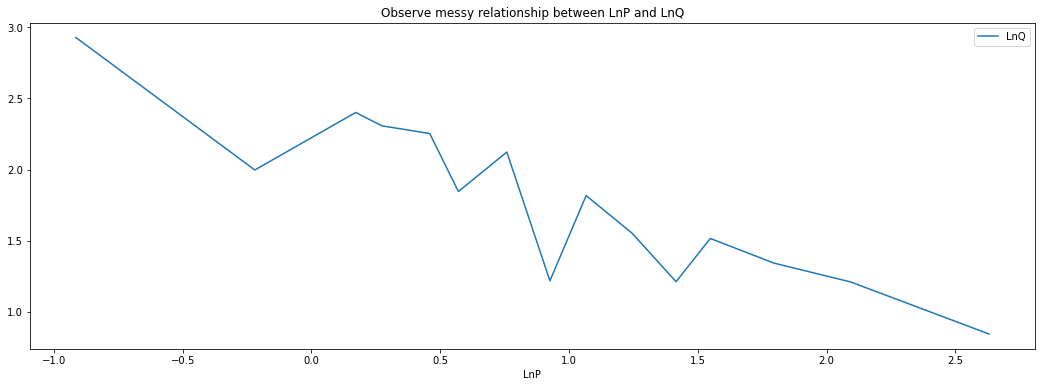

In [14]:
ols_fit = binned_ols(
    df_mdl,
    x='LnP',
    y='LnQ',
    n_bins=15,
    plot_title='Observe messy relationship between LnP and LnQ'
)

print(f'"Naive" elasticity estimated to be {ols_fit.params["LnP"]}')
ols_fit.summary()

```
Build standard econometrics-style causal model
There is a subtle point here about regularization: the full model matrix (see below) has a lot of collinearity, so there is no unique solution to OLS. Given the number of regressors, we wouldn't expect all of them to be relevant. Either argument leads us to regularizing the regression: either to yield a unique solution, or to encode our prior, or both.

But since we are interested in elasticity, i.e. the regression coefficient of LnP, we shouldn't regularize that particular feature! The larger our regularization-, the smaller the coefficient of interest would be. Unfortunately, most libraries don't allow removing features from penalization. So instead, I wiggled  and manually verified that scaling LnP doesn't change its coefficient (multiplying LnP by 10 multiplies the optimal coefficient by 0.1, reducing penalty).

Under ideal conditions (lots of obs where ), we would prefer ZINB loss (negative binomial deals with overdispersion, zero-inflation with long-tail of products). To keep things simple, let's go with Poisson.

To show that the distributional assumption has a large effect, we are also fitting OLS (i.e. Gaussian loss, or MSE).
```

In [15]:
import sklearn.preprocessing

In [16]:
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
feature_generator_basic = ColumnTransformer(
    [
        ('StockCode', OneHotEncoder(), ['StockCode']),
        ('Date', OneHotEncoder(), ['Date']),
        ('Country', OneHotEncoder(), ['Country']),
        ('LnP', 'passthrough', ['LnP']),
    ], remainder='drop'
)

mdl_basic = Pipeline([
    ('feat_proc', feature_generator_basic),
    ('reg', linear_model.PoissonRegressor(
        alpha=1e-6,  # l2 penalty strength; manually selected value for minimum interference on LnP-coef (elasticity)
        fit_intercept=False, # no need, since we have OneHot encodings without drop
        max_iter=100_000, 
    )),
], verbose=True)

mdl_basic_ols = Pipeline([
    ('feat_proc', feature_generator_basic),
    ('reg', linear_model.Ridge(
        alpha=1e-20,  # l2 penalty strength, "very small"
        fit_intercept=False, 
        max_iter=100_000, 
    )),
], verbose=True)

In [18]:
mdl_basic.fit(
    df_mdl[['LnP', 'StockCode', 'Date', 'Country']], 
    df_mdl['Quantity'] # Poisson regression has log-link, so LnQ is implicit in loss function
)

[Pipeline] ......... (step 1 of 2) Processing feat_proc, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing reg, total=   0.3s


Pipeline(steps=[('feat_proc',
                 ColumnTransformer(transformers=[('StockCode', OneHotEncoder(),
                                                  ['StockCode']),
                                                 ('Date', OneHotEncoder(),
                                                  ['Date']),
                                                 ('Country', OneHotEncoder(),
                                                  ['Country']),
                                                 ('LnP', 'passthrough',
                                                  ['LnP'])])),
                ('reg',
                 PoissonRegressor(alpha=1e-06, fit_intercept=False,
                                  max_iter=100000))],
         verbose=True)

In [19]:
mdl_basic_ols.fit(
    df_mdl[['LnP', 'StockCode', 'Date', 'Country']], 
    df_mdl['LnQ'] # log-normal
)

[Pipeline] ......... (step 1 of 2) Processing feat_proc, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing reg, total=   0.0s


Pipeline(steps=[('feat_proc',
                 ColumnTransformer(transformers=[('StockCode', OneHotEncoder(),
                                                  ['StockCode']),
                                                 ('Date', OneHotEncoder(),
                                                  ['Date']),
                                                 ('Country', OneHotEncoder(),
                                                  ['Country']),
                                                 ('LnP', 'passthrough',
                                                  ['LnP'])])),
                ('reg',
                 Ridge(alpha=1e-20, fit_intercept=False, max_iter=100000))],
         verbose=True)

In [20]:
print('"Econometrically" estimated elasticity with unit-, time-, and market- controls, using Poisson loss (coef on LnP):')
coef = pd.DataFrame({
    'feat': mdl_basic['feat_proc'].get_feature_names(),
    'coef': mdl_basic['reg'].coef_
})
coef.iloc[-1]

"Econometrically" estimated elasticity with unit-, time-, and market- controls, using Poisson loss (coef on LnP):


C:\ancon\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


feat        LnP
coef   -2.31336
Name: 1422, dtype: object

In [21]:
print('"Econometrically" estimated elasticity with unit-, time-, and market- controls, using log-Normal loss (coef on LnP):')
pd.DataFrame({
    'feat': mdl_basic_ols['feat_proc'].get_feature_names(),
    'coef': mdl_basic_ols['reg'].coef_
}).iloc[-1]

"Econometrically" estimated elasticity with unit-, time-, and market- controls, using log-Normal loss (coef on LnP):


feat        LnP
coef   -1.73275
Name: 1422, dtype: object

```Ouch. This large difference between Poisson and log-normal estimates is bad news for the DML approach to follow: in a real-life example, we should use DML within a Poisson regression, not log-normal. But for illustrative purposes, let's press on.

# The significant difference in estimates for log-normal vs. Poisson
# is explained by Poisson's fat tails: noisy/extreme values have a stronger
# effect in log-normal than in Poisson.
```

C:\ancon\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ancon\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


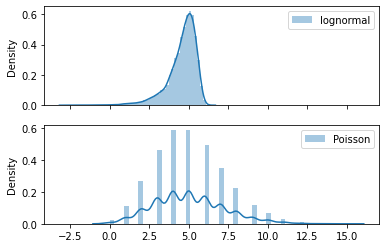

In [22]:

f, ax = plt.subplots(2, 1, sharex=True)
pos_normal = np.random.normal(loc=100, scale=100, size=12_000)
pos_normal = pos_normal[pos_normal > 0]
sns.distplot(np.log(pos_normal), label='lognormal', ax=ax[0])
sns.distplot(np.random.poisson(lam=5, size=10_000), label='Poisson', ax=ax[1])

ax[0].legend()
ax[1].legend()

<AxesSubplot:title={'center':'Date fixed effects track (avg) sales, but not perfectly: Deviation is explained by large effect of individual items [unit-normalized data]'}, xlabel='Date'>

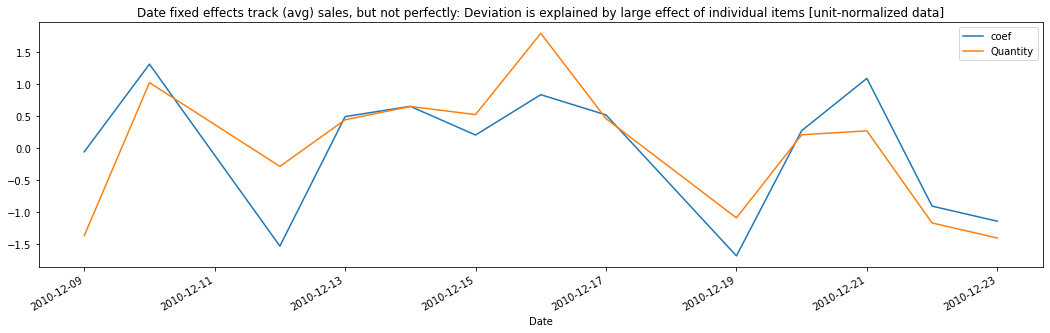

In [23]:
# For some intuition about this regression, convince ourselves that
# the time fixed effects do inded track quantity sold over time
# The divergence of q and time-coefs at the beginning and end likely 
# points towards new products that are introduced/old ones that are faded out
(
    pd.concat(
        [
            coef[coef.feat.str.startswith('Date')].reset_index(drop=True),
            df_mdl.groupby('Date').Quantity.sum().reset_index()
        ], 
        axis=1
    )
    .set_index(['Date'])
    .drop(columns=['feat'])
    .pipe(
        lambda d: (d - d.mean()) / d.std()
    )
).plot(
    figsize=(18, 5),
    title='Date fixed effects track (avg) sales, but not perfectly: Deviation is explained by large effect of individual items [unit-normalized data]'
)

```
Step 0: delta-log-scale & feature engineering
Effectively, we are adding the prior of item-level effects to our preprocessing: Instead of just taking logs, we already de-mean the data on item level, effectively taking out variation over products. Note that this is equivalent to adding an item-level fixed effect to a regression model.

and conversely for quantity.

Implemented features

Month, DoW, DoM
something bag-of-word-y to recover SKU categories/taxonomy
stock age (for trends)
SKU price level ("expensiveness", independent of within-SKU price variation)
feasible but deprioritized features

return customer
SKUs that tend to be only item in order vs. add-on items
graph clustering on orders to recover complements
```

In [24]:
# Note that de-meaning happens on StockCode-level here!
df_mdl['dLnP'] = np.log(df_mdl.UnitPrice) - np.log(df_mdl.groupby('StockCode').UnitPrice.transform('mean'))
df_mdl['dLnQ'] = np.log(df_mdl.Quantity) - np.log(df_mdl.groupby('StockCode').Quantity.transform('mean')) 

```Note that our item-level de-meaning already effectively controls for StockCode-level effects, yielding naive average elasticity```

In [25]:
df_mdl[['dLnP', 'dLnQ']].cov()

,dLnP,dLnQ
dLnP,0.096184,-0.135713
dLnQ,-0.135713,1.230836


In [26]:
df_mdl = df_mdl.assign(
    month = lambda d: d.Date.dt.month,
    DoM =   lambda d: d.Date.dt.day,
    DoW =   lambda d: d.Date.dt.weekday,
    stock_age_days = lambda d: 
        (d.Date - d.groupby('StockCode').Date.transform('min')).dt.days,
    sku_avg_p = lambda d: 
        d.groupby('StockCode').UnitPrice.transform('median')
)

```Step 1: auxiliary models to orthogonalize T (price) and Y (quantity)
Note that since we're using RandomForests, we should be a little careful about features: one-hot encoded (SKU, date, country) in principle allows the trees to fully overfit each observation (we summarized the data to that level above). As a simple workaround, and since we are using dLnP/dLnQ anyway, we are just removing StockCode from the features - SKU fixed effects have already been removed by construction.```

In [27]:
from sklearn.ensemble import RandomForestRegressor

In [28]:
feature_generator_full = ColumnTransformer(
    [
        # do NOT include to reduce overfit (price is sku-level-demeaned anyway): 
        # ('StockCode', OneHotEncoder(), ['StockCode']), 
        ('Date', OneHotEncoder(), ['Date']),
        ('Description', CountVectorizer(min_df=0.0025, ngram_range=(1, 3)), 'Description'),
        ('Country', OneHotEncoder(), ['Country']),
        ('numeric_feats', StandardScaler(), ['month', 'DoM', 'DoW', 'stock_age_days', 'sku_avg_p']),
    ], remainder='drop'
)

In [29]:
 = Pipeline([
    ('feat_proc', feature_generator_full),
    ('model_y', RandomForestRegressor(n_estimators=50, min_samples_leaf=3, n_jobs=-1, verbose=0)) 
    # n_samples_leaf/n_estimators is set to reduce model (file) size and runtime
    # larger models yield prettier plots.
])
model_t = Pipeline([
    ('feat_proc', feature_generator_full),
    ('model_t', RandomForestRegressor(n_estimators=50, min_samples_leaf=3, n_jobs=-1, verbose=0))
])

In [33]:
model_y.fit(df_mdl, df_mdl.dLnQ)
model_t.fit(df_mdl, df_mdl.dLnP)

Pipeline(steps=[('feat_proc',
                 ColumnTransformer(transformers=[('Date', OneHotEncoder(),
                                                  ['Date']),
                                                 ('Description',
                                                  CountVectorizer(min_df=0.0025,
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'Description'),
                                                 ('Country', OneHotEncoder(),
                                                  ['Country']),
                                                 ('numeric_feats',
                                                  StandardScaler(),
                                                  ['month', 'DoM', 'DoW',
                                                   'stock_age_days',
                                                   'sku_avg_p'])])),
                ('model_t',
                 RandomForestRegressor(min_samples_leaf=3, n_estimators=50,
                                       n_jobs=-1))])

In [34]:
# Get first-step, predictions to residualize ("orthogonalize") with (in-sample for now)
q_hat = model_y.predict(df_mdl)
p_hat = model_t.predict(df_mdl)

In [35]:
df_mdl = df_mdl.assign(
    dLnP_res = df_mdl['dLnP'] - p_hat,
    dLnQ_res = df_mdl['dLnQ'] - q_hat,
)

"Average" elasticity estimated using DML to be -1.735
Note that this is close to our econometric contols - some difference comes from the different distribution assumptions (Poisson vs. log-normal)


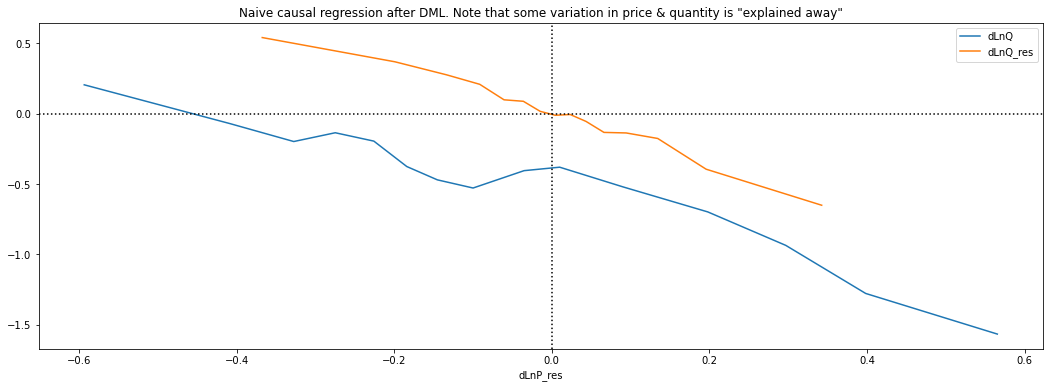

In [36]:
old_fit = binned_ols(
    df_mdl,
    x='dLnP',
    y='dLnQ',
    n_bins=15,
)

old_fit = binned_ols(
    df_mdl,
    x='dLnP_res',
    y='dLnQ_res',
    n_bins=15,
    plot_title='Naive causal regression after DML. Note that some variation in price & quantity is "explained away"',
    plot_ax=plt.gca()
)

plt.gca().axvline(0, color='k', linestyle=':')
plt.gca().axhline(0, color='k', linestyle=':')


print(
    f'"Average" elasticity estimated using DML to be {old_fit.params["dLnP_res"]:.3f}\n'
    'Note that this is close to our econometric contols - some difference comes from the different distribution '
    'assumptions (Poisson vs. log-normal)'
)

"Average" elasticity estimated using DML (now supposedly valid estimate!) to be -1.735
Note that this is close to our econometric contols - some difference comes from the different distribution assumptions (Poisson vs. log-normal)


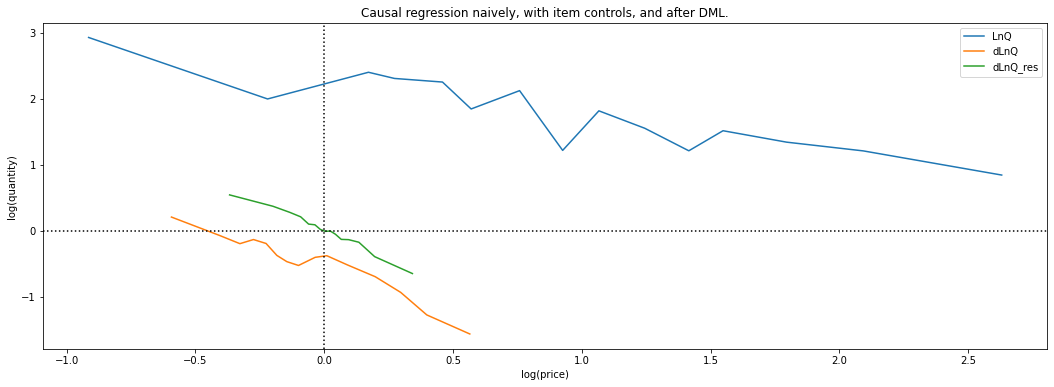

In [37]:
old_fit = binned_ols(
    df_mdl,
    x='LnP',
    y='LnQ',
    n_bins=15,
)

old_fit = binned_ols(
    df_mdl,
    x='dLnP',
    y='dLnQ',
    n_bins=15,
    plot_ax=plt.gca(),
)

old_fit = binned_ols(
    df_mdl,
    x='dLnP_res',
    y='dLnQ_res',
    n_bins=15,
    plot_title='Causal regression naively, with item controls, and after DML.',
    plot_ax=plt.gca()
)
plt.gca().set(
    xlabel='log(price)',
    ylabel='log(quantity)',    
)

plt.gca().axvline(0, color='k', linestyle=':')
plt.gca().axhline(0, color='k', linestyle=':')


print(
    f'"Average" elasticity estimated using DML (now supposedly valid estimate!) to be {old_fit.params["dLnP_res"]:.3f}\n'
    'Note that this is close to our econometric contols - some difference comes from the different distribution '
    'assumptions (Poisson vs. log-normal)'
)

In [38]:
def get_feat_generator_names(gen):
    # workaround to sklearn native .get_feature_names() failing
    # because StandardScaler strangely doesn't implement it
    res = []
    for i, (k, t) in enumerate(gen.named_transformers_.items()):
        if k == 'remainder':
            continue
        try: 
            res += [f'{k}_{n}' for n in t.get_feature_names()]
        except:
            res += list(gen.transformers_[i][2])
    return res

C:\ancon\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'feature importances for DML estimators of treatment(p) and outcome(q)'}, ylabel='feat'>

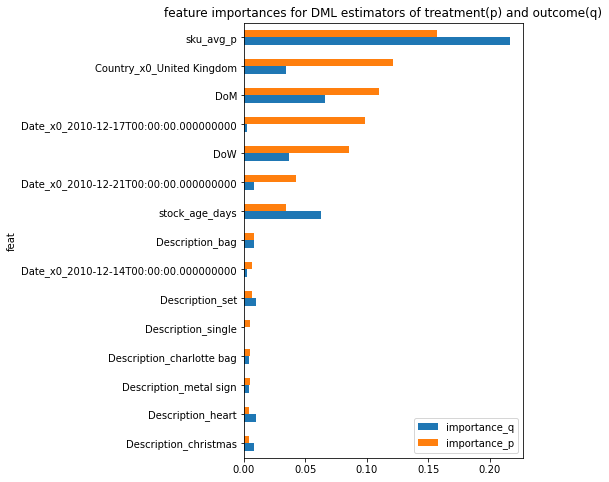

In [39]:
feat_imp = pd.DataFrame({
    'feat': get_feat_generator_names(model_y['feat_proc']),
    'importance_q': model_y['model_y'].feature_importances_,
    'importance_p': model_t['model_t'].feature_importances_,
}).set_index('feat')

feat_imp.sort_values(
    by='importance_p'
).iloc[-15:].plot.barh(
    figsize=(5, 8), 
    title='feature importances for DML estimators of treatment(p) and outcome(q)'
)

```
Step 2: Inferential model for causal elasticity
Now, the inferential model is trying to predict 
 
. After residualizing, dLnP_res is often very small. These values blow up our estimator - so to reduce noisiness, we are dropping all observations with very small residual price variation. Arguably, they don't contain much information anyway, because there is so little price variation left.

There is one more technicality in DML: Chernozhukov proposes using a slightly different estimator of treatment effect than standard OLS for robustness reasons. Instead of taking the standard OLS-solution, 
, Chernozhukov uses the following, de-biased estimator. Note that the first  is residualized, while the second is not, and the third is.

This estimator is fit 2-fold, once on either half of the data (the other half being used for the auxiliary models). The average between both fits is an efficient estimator. Below, DML is implemented "properly": with sample splitting, and debiased estimator.
```

In [40]:
from sklearn.model_selection import KFold

fitting model_y
fitting model_t
DML elast:  -1.306521510896463
OLS elasticity for comparison: -1.7480026383725553
fitting model_y
fitting model_t
DML elast:  -1.2786894172927283
OLS elasticity for comparison: -1.6701460029242696
DML efficient estimate of elasticity: -1.2926054640945956


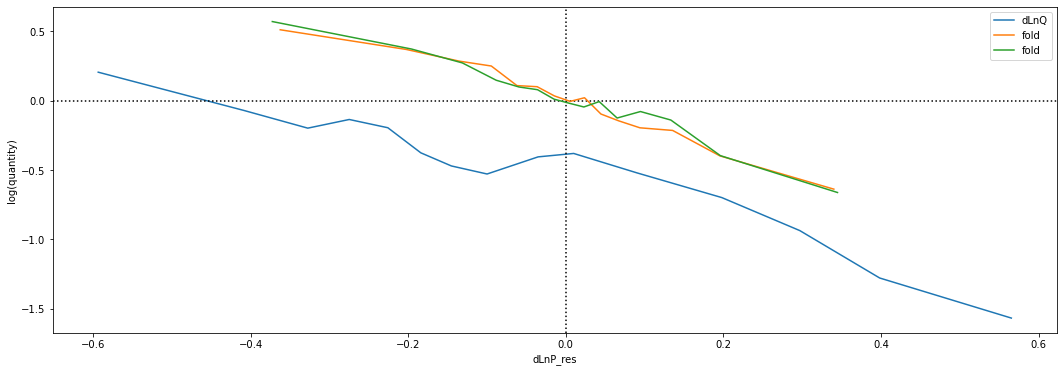

In [43]:
old_fit = binned_ols(
    df_mdl,
    x='dLnP',
    y='dLnQ',
    n_bins=15,
    plot_ax=plt.gca(),
)
plt.gca().set(
    xlabel='log(price)',
    ylabel='log(quantity)',    
)
plt.gca().axvline(0, color='k', linestyle=':')
plt.gca().axhline(0, color='k', linestyle=':')


elast_estimates = list()
for idx_aux, idx_inf in KFold(
    n_splits=2, shuffle=True).split(df_mdl):
    
    df_aux = df_mdl.iloc[idx_aux]
    df_inf = df_mdl.iloc[idx_inf].copy()
    
    # step 1: aux models and residualize in inferential set
    print('fitting model_y')
    model_y.fit(df_aux, df_aux.dLnQ)
    print('fitting model_t')
    model_t.fit(df_aux, df_aux.dLnP)
    

    
    binned_ols(
        df_inf,
        x='dLnP_res',
        y='dLnQ_res',
        n_bins=15,
        plot_ax=plt.gca(),
        label='fold'
    )

    
    # ignore observations where we residualized away all variation in price
    mask = (~(df_inf.dLnP_res.abs() < 0.01))
    df_inf_censored = df_inf[mask]
    
    # step 2.1: Chernozhukov DML inference
    elast = (
        df_inf_censored['dLnP_res'].dot(df_inf_censored['dLnQ_res'])
        /
        df_inf_censored['dLnP_res'].dot(df_inf_censored['dLnP'])
        # the last part here deviates from standard OLS solution
    )
    
    print('DML elast: ', elast)
    elast_estimates.append(elast)

    print('OLS elasticity for comparison:',
        df_inf_censored['dLnP_res'].dot(df_inf_censored['dLnQ_res'])
        /
        df_inf_censored['dLnP_res'].dot(df_inf_censored['dLnP_res'])
    )    

    elast_estimates.append(elast)

print("DML efficient estimate of elasticity:", np.mean(elast_estimates))